## Yelp Review Stream

In [177]:
import numpy as np
import pandas as pd
import json
import time
import datetime
import nltk
import string
import sys
import math
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Define some constants
file = 'E:\\yelp_dataset\\review.json'
opinion_lexicon_path = 'E:\\yelp_dataset\\opinion_lexicon'

batch_size = 10000

### 1. Since the data file is too large to load into memory at once, it has to be processed in batches.
### 2. The batches are then processed one review at a time and the sufficient statistics are collected. The batch of reviews is then discarded.
### 3. The sufficient stats are dumped to the disk as a csv after each batch, so that they can be used to calculate stream summary information, such as the average number of positive words in a review.

In [6]:
class YelpReviews:

    def __init__(self):

        self.reviews_df = pd.DataFrame()
        self.timepoint_statistics = pd.DataFrame()
        self.positive_words = set()
        self.negative_words = set()
        self._open_lexicon()
        self.feature_vector = ['review_id', 'user_id', 'business_id', 'stars', 'text',
                               'date', 'num_words', 'num_pos_words', 'num_neg_words']

        # Create the structures for the details to be calculated
        self.reviews_n = Counter()
        self.pos_reviews_n = Counter()
        self.neg_reviews_n = Counter()

        self.words_ls = Counter()
        self.words_ss = Counter()
        self.pos_words_ls = Counter()
        self.pos_words_ss = Counter()
        self. neg_words_ls = Counter()
        self.neg_words_ss = Counter()
        self.unique_users = Counter()
        self.unique_users_set = set()

    def _open_lexicon(self):
        """
        Create positive and negative words sets from the lexicon file
        """
        # Positive Lexicon
        with open(opinion_lexicon_path + '/positive-words.txt', encoding='iso-8859-1') as f:
            positive_words = np.loadtxt(f, comments=';', dtype='bytes')
        positive_words = [x.decode('us-ascii') for x in positive_words]
        self.positive_words = set(positive_words)

        # Negative Lexicon
        with open(opinion_lexicon_path + '/negative-words.txt', encoding='iso-8859-1') as f:
            negative_words = np.loadtxt(f, comments=';', dtype='bytes')
        negative_words = [x.decode('iso-8859-1') for x in negative_words.tolist()]
        self.negative_words = set(negative_words)

    def _create_reviews_df(self, reviews):
        """
        Create a dataframe of reviews and calculate some statistics
        """
        # Create the reviews dataframe from the list of reviews
        reviews_df = pd.DataFrame(reviews)
        # Convert the date field from string to date
        reviews_df['date'] = pd.to_datetime(reviews_df['date']).dt.date
        # Sort by date
        reviews_df = reviews_df.sort_values(by='date')

        # Tokens of the review text with punctuation removed, so that count of words,
        # neg words, pos words can be obtained
        reviews_df['tokens'] = reviews_df['text'].apply(
            lambda text: [word for word in nltk.word_tokenize(text) if word not in string.punctuation])

        # Count of total words, positive words, and negative words
        reviews_df['num_words'] = reviews_df['tokens'].apply(len)
        reviews_df['num_pos_words'] = reviews_df['tokens'].apply(
            lambda tokens: len(self.positive_words.intersection(tokens)))
        reviews_df['num_neg_words'] = reviews_df['tokens'].apply(
            lambda tokens: len(self.negative_words.intersection(tokens)))
        self.reviews_df = reviews_df[self.feature_vector]

    def _create_timepoint_dataframe(self):
        """
        Create timepoint statistics dataframe and save to disk
        """
        # Create dataframes from the counters to view the results in a tabular format
        reviews_n = pd.DataFrame.from_dict(self.reviews_n, orient='index', columns=['reviews_n'])
        pos_reviews_n = pd.DataFrame.from_dict(self.pos_reviews_n, orient='index',
                                               columns=['pos_reviews_n'])
        neg_reviews_n = pd.DataFrame.from_dict(self.neg_reviews_n, orient='index',
                                               columns=['neg_reviews_n'])

        words_ls = pd.DataFrame.from_dict(self.words_ls, orient='index', columns=['words_ls'])
        words_ss = pd.DataFrame.from_dict(self.words_ss, orient='index', columns=['words_ss'])

        pos_words_ls = pd.DataFrame.from_dict(self.pos_words_ls, orient='index', columns=['pos_words_ls'])
        pos_words_ss = pd.DataFrame.from_dict(self.pos_words_ss, orient='index', columns=['pos_words_ss'])

        neg_words_ls = pd.DataFrame.from_dict(self.neg_words_ls, orient='index', columns=['neg_words_ls'])
        neg_words_ss = pd.DataFrame.from_dict(self.neg_words_ss, orient='index', columns=['neg_words_ss'])

        unique_users_n = pd.DataFrame.from_dict(self.unique_users, orient='index', columns=['unique_users_n'])

        # Combine the dataframes into one
        self.timepoint_statistics = pd.concat([words_ls, words_ss, reviews_n, pos_words_ls, pos_words_ss,
                                               pos_reviews_n, neg_words_ls, neg_words_ss, neg_reviews_n,
                                               unique_users_n],
                                              axis=1, sort=True)
        # Fill na values with 0 
        self.timepoint_statistics.fillna(0, inplace=True)

        # Save the calculated statistics as a csv
        self.timepoint_statistics.to_csv('yelp_reviews_statistics.csv')

    def _calculate_timepoint_statistics(self):
        """
        Update statistics for each batch of reviews
        """
        # Iterate through the review dateframe and increment counters
        for row in self.reviews_df.itertuples():

            # Get the date in the format YYYY_MM so that counters for that timepoint can be incremented
            timepoint = str(row.date.year) + '-' + str(+ row.date.month)

            # Increment counters
            self.reviews_n[timepoint] += 1
            if row.stars >= 4:
                self.pos_reviews_n[timepoint] += 1
            elif row.stars <= 2:
                self.neg_reviews_n[timepoint] += 1

            self.words_ls[timepoint] += row.num_words
            self.words_ss[timepoint] += row.num_words**2

            self.pos_words_ls[timepoint] += row.num_pos_words
            self.pos_words_ss[timepoint] += row.num_pos_words**2

            self.neg_words_ls[timepoint] += row.num_neg_words
            self.neg_words_ss[timepoint] += row.num_neg_words**2

            if row.user_id not in self.unique_users_set:
                self.unique_users_set.add(row.user_id)
                self.unique_users[timepoint] += 1

    def get_stats_upto_timepoint(self, timepoint):
        """
        Get statistics upto the specified timepoint
        """
        self.timepoint_statistics.sort_index(inplace=True)

        reviews_n = self.timepoint_statistics[:timepoint]['reviews_n'].sum()
        pos_reviews_n = self.timepoint_statistics[:timepoint]['pos_reviews_n'].sum()
        neg_reviews_n = self.timepoint_statistics[:timepoint]['neg_reviews_n'].sum()

        words_ls = self.timepoint_statistics[:timepoint]['words_ls'].sum()
        words_ss = self.timepoint_statistics[:timepoint]['words_ss'].sum()

        pos_words_ls = self.timepoint_statistics[:timepoint]['pos_words_ls'].sum()
        pos_words_ss = self.timepoint_statistics[:timepoint]['pos_words_ss'].sum()

        neg_words_ls = self.timepoint_statistics[:timepoint]['neg_words_ls'].sum()
        neg_words_ss = self.timepoint_statistics[:timepoint]['neg_words_ss'].sum()

        unique_users_n = self.timepoint_statistics[:timepoint]['unique_users_n'].sum()

        mean_words_per_review = words_ls / reviews_n
        sigma_words_per_review = (
            math.sqrt((words_ss/reviews_n) - (words_ls/reviews_n)**2)
        )

        mean_pos_words_per_review = pos_words_ls / reviews_n
        sigma_pos_words_per_review = (
            math.sqrt((pos_words_ss / reviews_n) - (pos_words_ls / reviews_n) ** 2)
        )
        mean_neg_words_per_review = neg_words_ls / reviews_n
        sigma_neg_words_per_review = (
            math.sqrt((neg_words_ss / reviews_n) - (neg_words_ls / reviews_n) ** 2)
        )

        statistics = {
            'reviews_n': reviews_n, 'pos_reviews_n': pos_reviews_n, 'neg_reviews_n': neg_reviews_n,
            'mean_words_per_review': mean_words_per_review,
            'sigma_words_per_review': sigma_words_per_review,
            'mean_pos_words_per_review': mean_pos_words_per_review,
            'sigma_pos_words_per_review': sigma_pos_words_per_review,
            'mean_neg_words_per_review': mean_neg_words_per_review,
            'sigma_neg_words_per_review': sigma_neg_words_per_review,
            'unique_users_n': unique_users_n
        }

        return statistics

    def process_reviews(self, reviews):
        """
        Process the batch of reviews
        """
        self._create_reviews_df(reviews)
        self._calculate_timepoint_statistics()
        self._create_timepoint_dataframe()

    def print_stats(self, statistics):
        """
        Display the statistics
        """
        print('Review Count: %d, Positive Reviews: %d, Negative Reviews: %d' %
              (statistics['reviews_n'], statistics['pos_reviews_n'], statistics['neg_reviews_n']))
        print()
        print('Mean Words           : %0.2f' % statistics['mean_words_per_review'])
        print('Sigma Words          : %0.2f' % statistics['sigma_words_per_review'])
        print()
        print('Mean Positive Words  : %0.2f' % statistics['mean_pos_words_per_review'])
        print('Sigma Positive Words : %0.2f' % statistics['sigma_pos_words_per_review'])
        print()
        print('Mean Negative Words  : %0.2f' % statistics['mean_neg_words_per_review'])
        print('Sigma Negative Words : %0.2f' % statistics['sigma_neg_words_per_review'])
        print()
        print('Unique Users         : %d' % statistics['unique_users_n'])


In [ ]:
# Create object
yelp_reviews = YelpReviews()

print('Processing reviews...')
with open(file, encoding="utf8") as fin:
    reviews = []
    st = time.time()
    # Read the json file line by line and keep adding the lines to a list
    for counter, line in enumerate(fin, 1):

        review = json.loads(line)
        reviews.append(review)

        # When batch size is reached, process the batch of reviews
        if counter % batch_size == 0:
            yelp_reviews.process_reviews(reviews)
            print('%d reviews processed in %0.2fs' % (counter, time.time() - st))
            reviews = []

In [ ]:
# Calculate statistics upto timepoint
timepoint = '2013-12'
statistics = yelp_reviews.get_stats_upto_timepoint(timepoint)

print('Timepoint: %s' % timepoint)
yelp_reviews.print_stats(statistics)

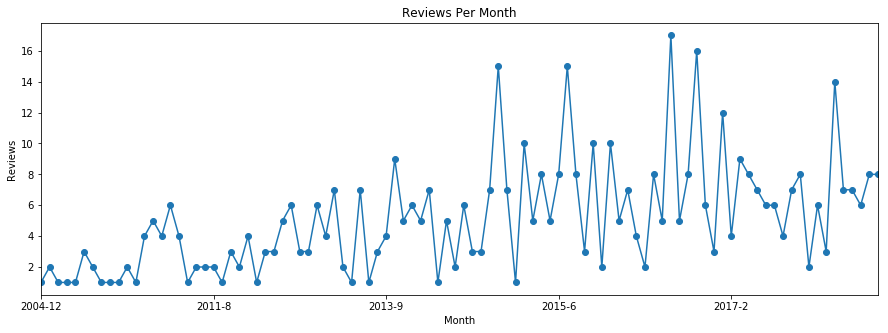

In [193]:
ax = timepoint_statistics['reviews_n'].plot.line(marker='o', title='Reviews Per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Reviews')
fig = plt.gcf()
fig.set_size_inches(15, 5, forward=True)
plt.show()
plt.close()

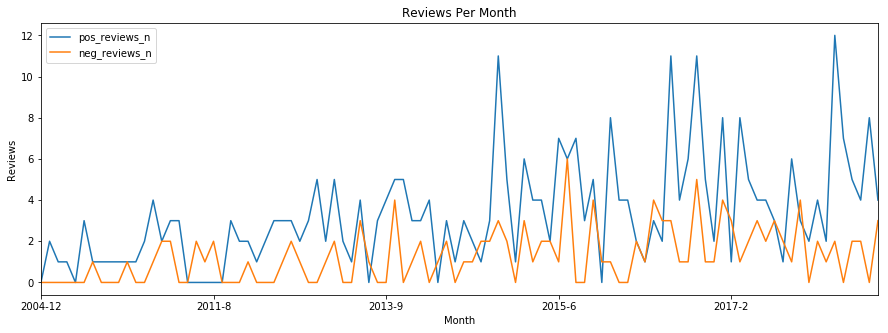

In [197]:
ax = timepoint_statistics[['pos_reviews_n', 'neg_reviews_n']].plot.line(title='Reviews Per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Reviews')
fig = plt.gcf()
fig.set_size_inches(15, 5, forward=True)
plt.show()
plt.close()

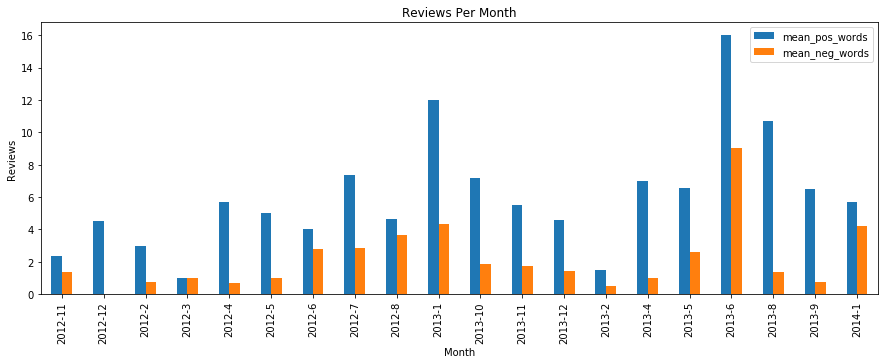

In [228]:
df = timepoint_statistics[['pos_words_ls', 'neg_words_ls', 'reviews_n']].loc['2012-1':'2014-1']
df['mean_pos_words'] = df.apply(lambda row: row.pos_words_ls / row.reviews_n, axis=1)
df['mean_neg_words'] = df.apply(lambda row: row.neg_words_ls / row.reviews_n, axis=1)
df = df[['mean_pos_words', 'mean_neg_words']]

ax = df.plot.bar(title='Reviews Per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Reviews')
fig = plt.gcf()
fig.set_size_inches(15, 5, forward=True)
plt.show()
plt.close()